# Plot PyPI download stats

## Download the data

You can download the data using the free Google Cloud BigQuery Sandbox APIs.

1. Set up a BiyQuery Sanbdox account following these instructions: https://cloud.google.com/bigquery/docs/sandbox.
2. Use the online console to run the query (before running the query you can see a preview of the usage in the top right). You have 10 TB of free queries per month. This is the query used shown in the screenshot (documentation here https://packaging.python.org/en/latest/guides/analyzing-pypi-package-downloads/).
```sql
#standardSQL
SELECT
  file.project AS project,
  COUNT(*) AS num_downloads,
  DATE_TRUNC(DATE(timestamp), MONTH) AS `month`
FROM `bigquery-public-data.pypi.file_downloads`
WHERE
  file.project IN ('spatialdata', 'muon', 'mudata', 'mofapy', 'mofapy2', 'cell2location', 'spatialde')
  -- Only query the last 5 years of history
  AND DATE(timestamp)
    BETWEEN DATE_TRUNC(DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR), MONTH)
    AND CURRENT_DATE()
GROUP BY project, `month`
ORDER BY `month` DESC, project
```

3. Download the data as a CSV file, here called `data.csv`.

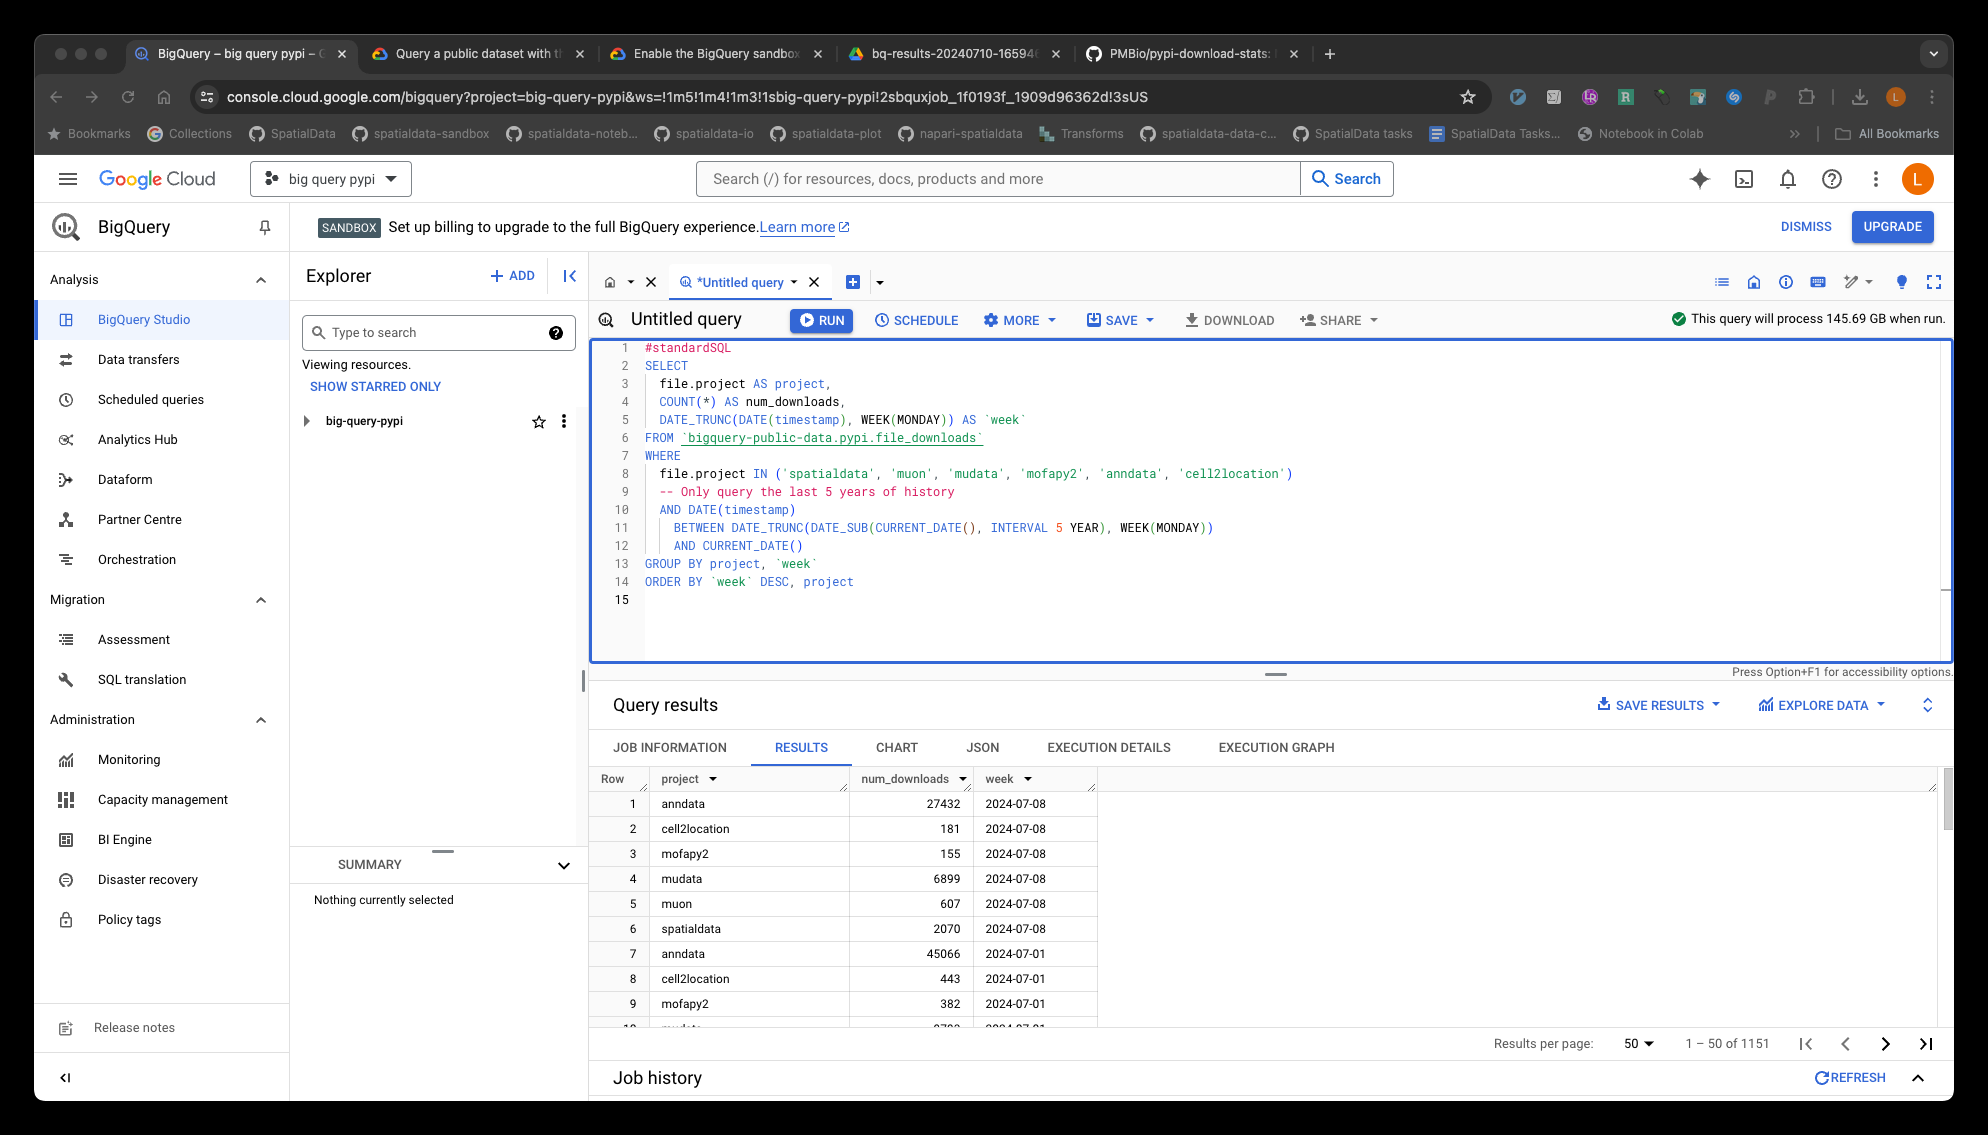

## Plot the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# Load the CSV file
file_path = 'data/bquxjob_133dd684_190a2683ff0.csv'
data = pd.read_csv(file_path)

data['month'] = pd.to_datetime(data['month'])

In [2]:
data

,project,num_downloads,month
0,cell2location,664,2024-07-01
1,mofapy2,588,2024-07-01
2,mudata,18774,2024-07-01
3,muon,2166,2024-07-01
4,spatialdata,8422,2024-07-01
...,...,...,...
326,mofapy,314,2019-11-01
327,mofapy,383,2019-10-01
328,mofapy,407,2019-09-01
329,mofapy,420,2019-08-01


In [3]:
data_r = pd.read_csv('data/mofa.csv')
data_r.drop(['end', 'Nb_of_distinct_IPs', 'Unnamed: 0'], axis=1, inplace=True)
data_r.rename(columns={'start': 'month', 'Nb_of_downloads': 'num_downloads', 'package': 'project'}, inplace=True)

In [4]:
data_r['month'] = pd.to_datetime(data_r['month'])

In [5]:
data = pd.concat([data, data_r]).reset_index()

In [6]:
# remove the current week since the data is incomplete until the week is over)
data = data[data['month'] != data['month'].max()]

# Get the unique projects
projects = data['project'].unique()
projects

array(['cell2location', 'mofapy2', 'mudata', 'muon', 'spatialdata',
       'spatialde', 'mofapy', 'MuData', 'MOFA', 'MOFA2'], dtype=object)

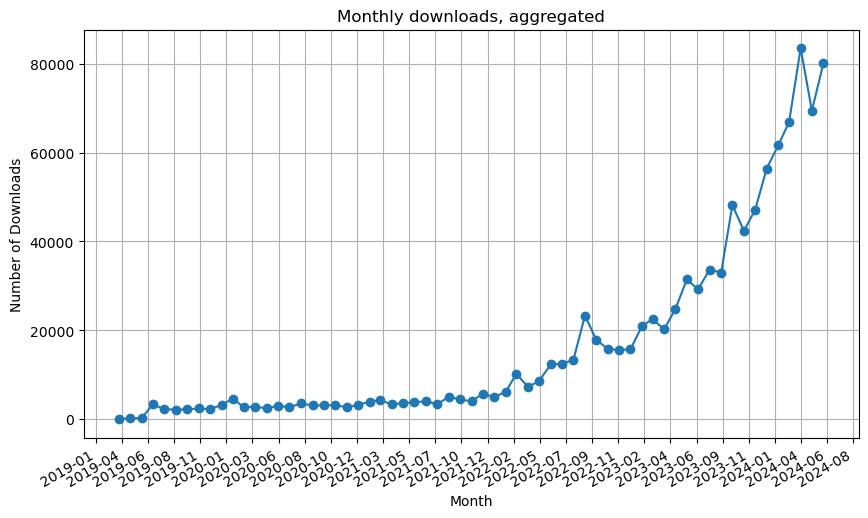

'aggregated_downloads_plots.pdf'

In [7]:
# aggregated
pdf_path = 'aggregated_downloads_plots.pdf'
with PdfPages(pdf_path) as pdf:
    project_data = data.drop('project', axis=1).groupby('month', as_index=False).sum()
    plt.figure(figsize=(10, 6))
    plt.plot(project_data['month'], project_data['num_downloads'], marker='o')
    plt.title(f'Monthly downloads, aggregated')
    plt.xlabel('Month')
    plt.ylabel('Number of Downloads')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
    plt.gcf().autofmt_xdate()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path

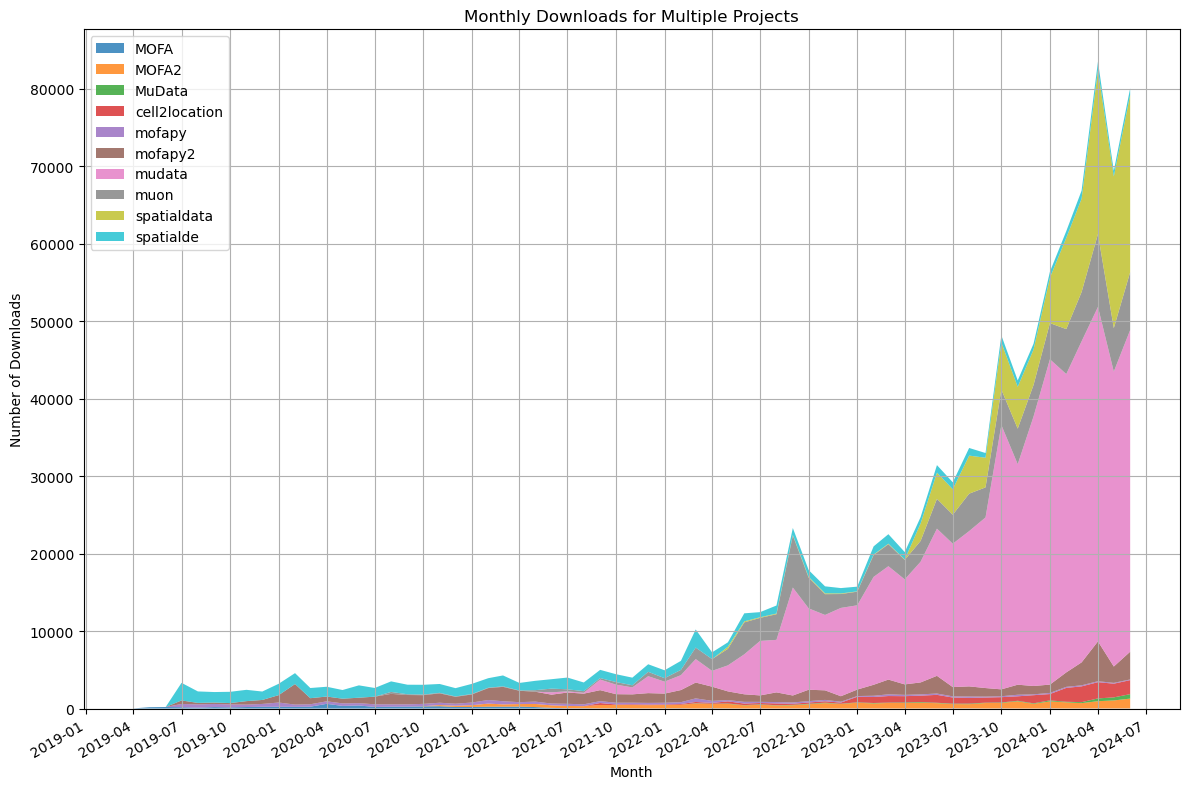

'monthly_downloads_stacked_plot.pdf'

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Assuming `data` is your DataFrame containing the data
# and `projects` is a list of project names

# Create a PDF with a single plot for all projects
pdf_path = 'monthly_downloads_stacked_plot.pdf'

# Prepare the data for plotting
data['month'] = pd.to_datetime(data['month'])
data = data.sort_values('month')

# Pivot the data to get projects as columns
pivot_df = data.pivot_table(index='month', columns='project', values='num_downloads', fill_value=0)

# Create a stacked area plot
with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(12, 8))
    
    plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.8)
    
    plt.title('Monthly Downloads for Multiple Projects')
    plt.xlabel('Month')
    plt.ylabel('Number of Downloads')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path


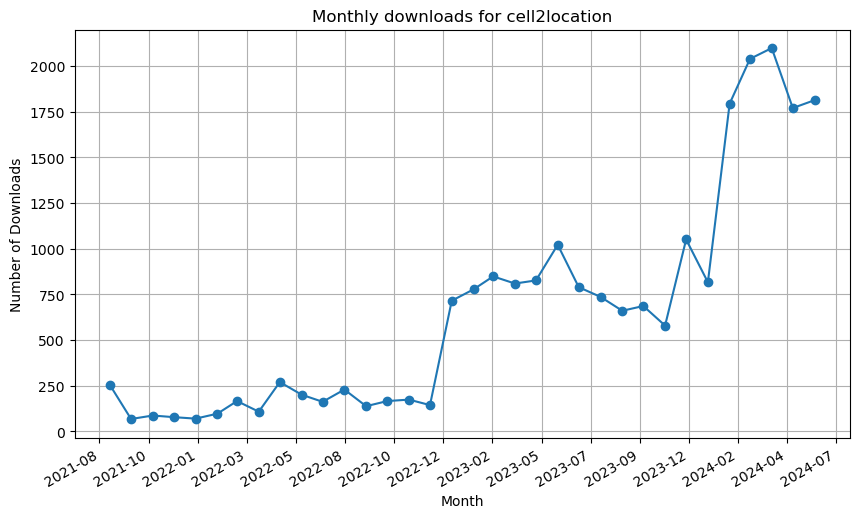

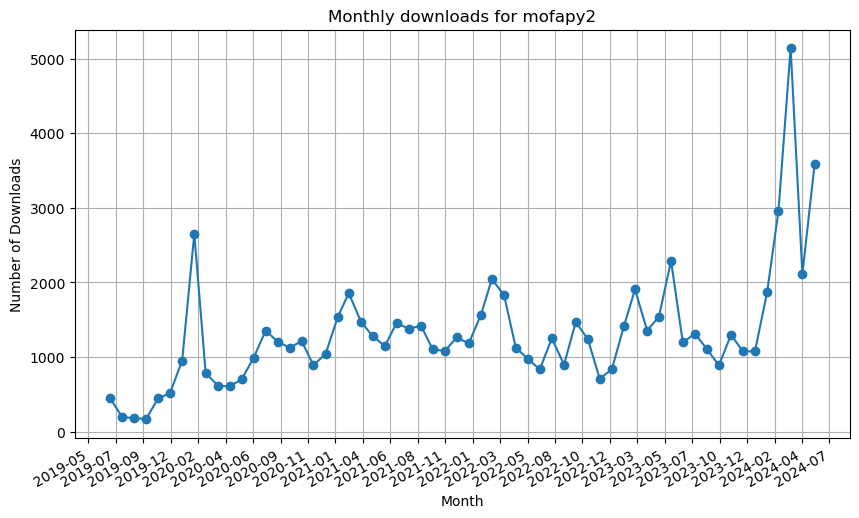

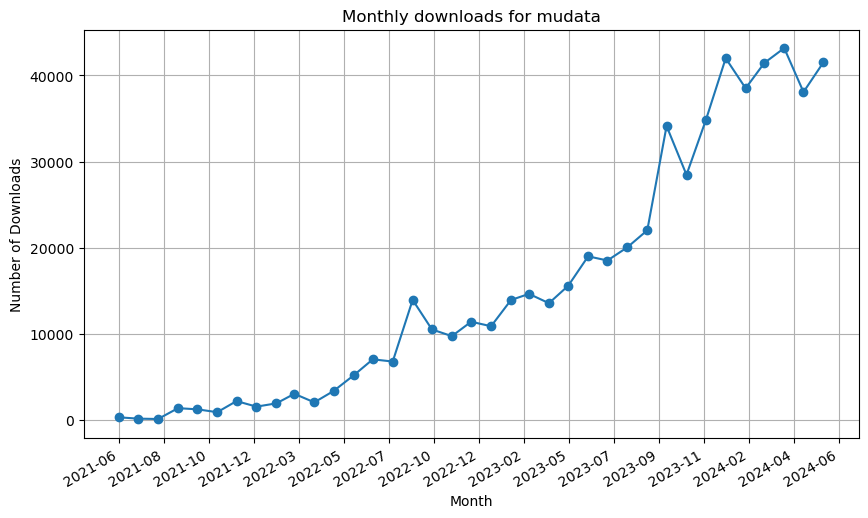

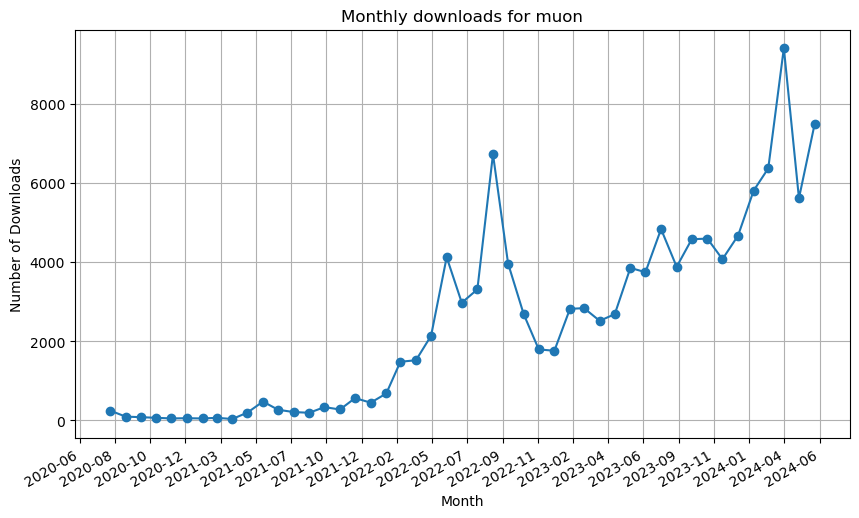

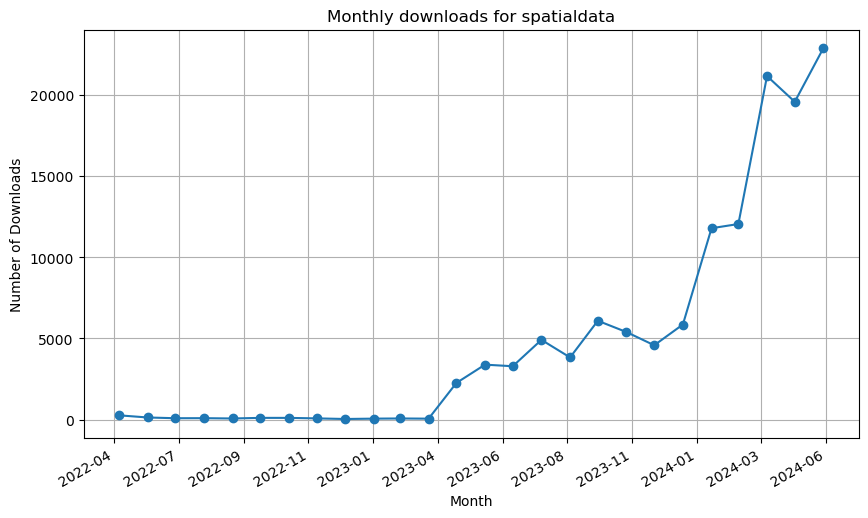

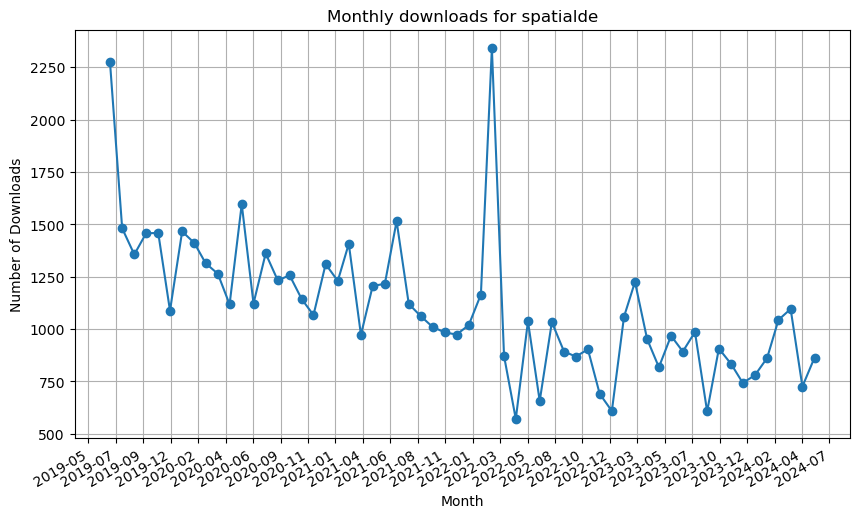

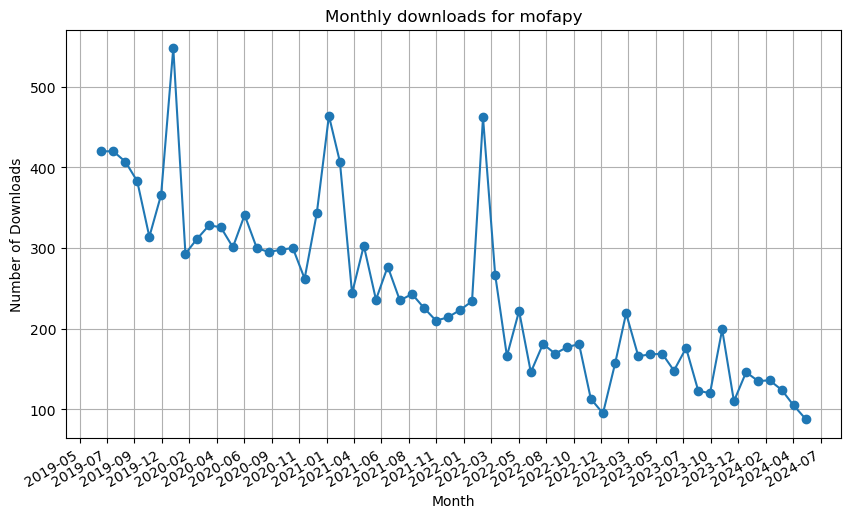

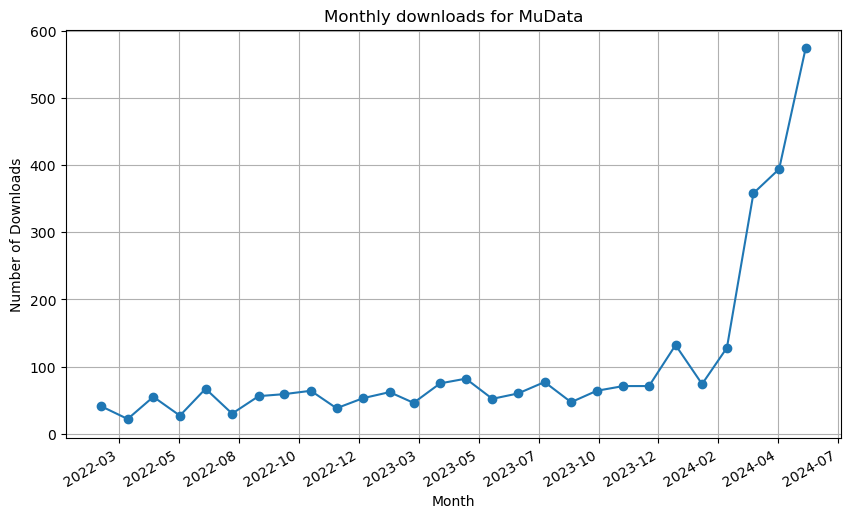

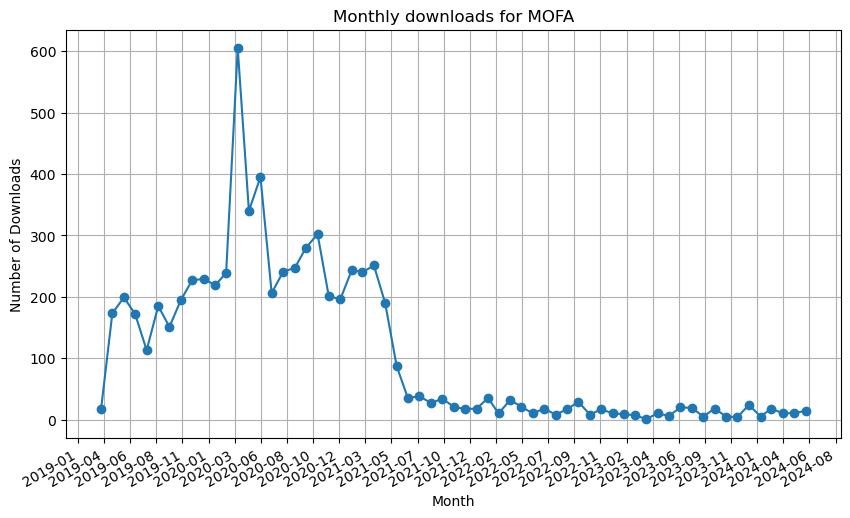

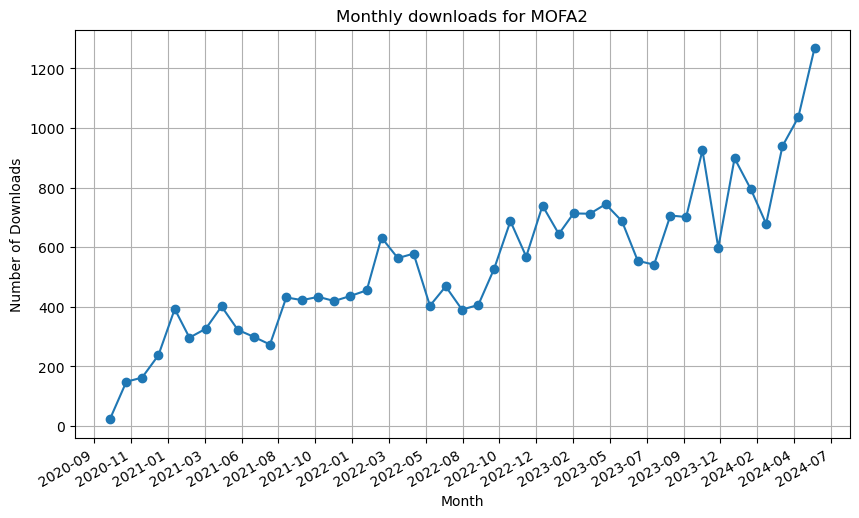

'monthly_downloads_plots.pdf'

In [9]:
# Create a PDF with plots for each project
pdf_path = 'monthly_downloads_plots.pdf'
with PdfPages(pdf_path) as pdf:
    for project in projects:
        project_data = data[data['project'] == project]
        plt.figure(figsize=(10, 6))
        plt.plot(project_data['month'], project_data['num_downloads'], marker='o')
        plt.title(f'Monthly downloads for {project}')
        plt.xlabel('Month')
        plt.ylabel('Number of Downloads')
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
        plt.gcf().autofmt_xdate()
        pdf.savefig()
        plt.show()
        plt.close()

pdf_path

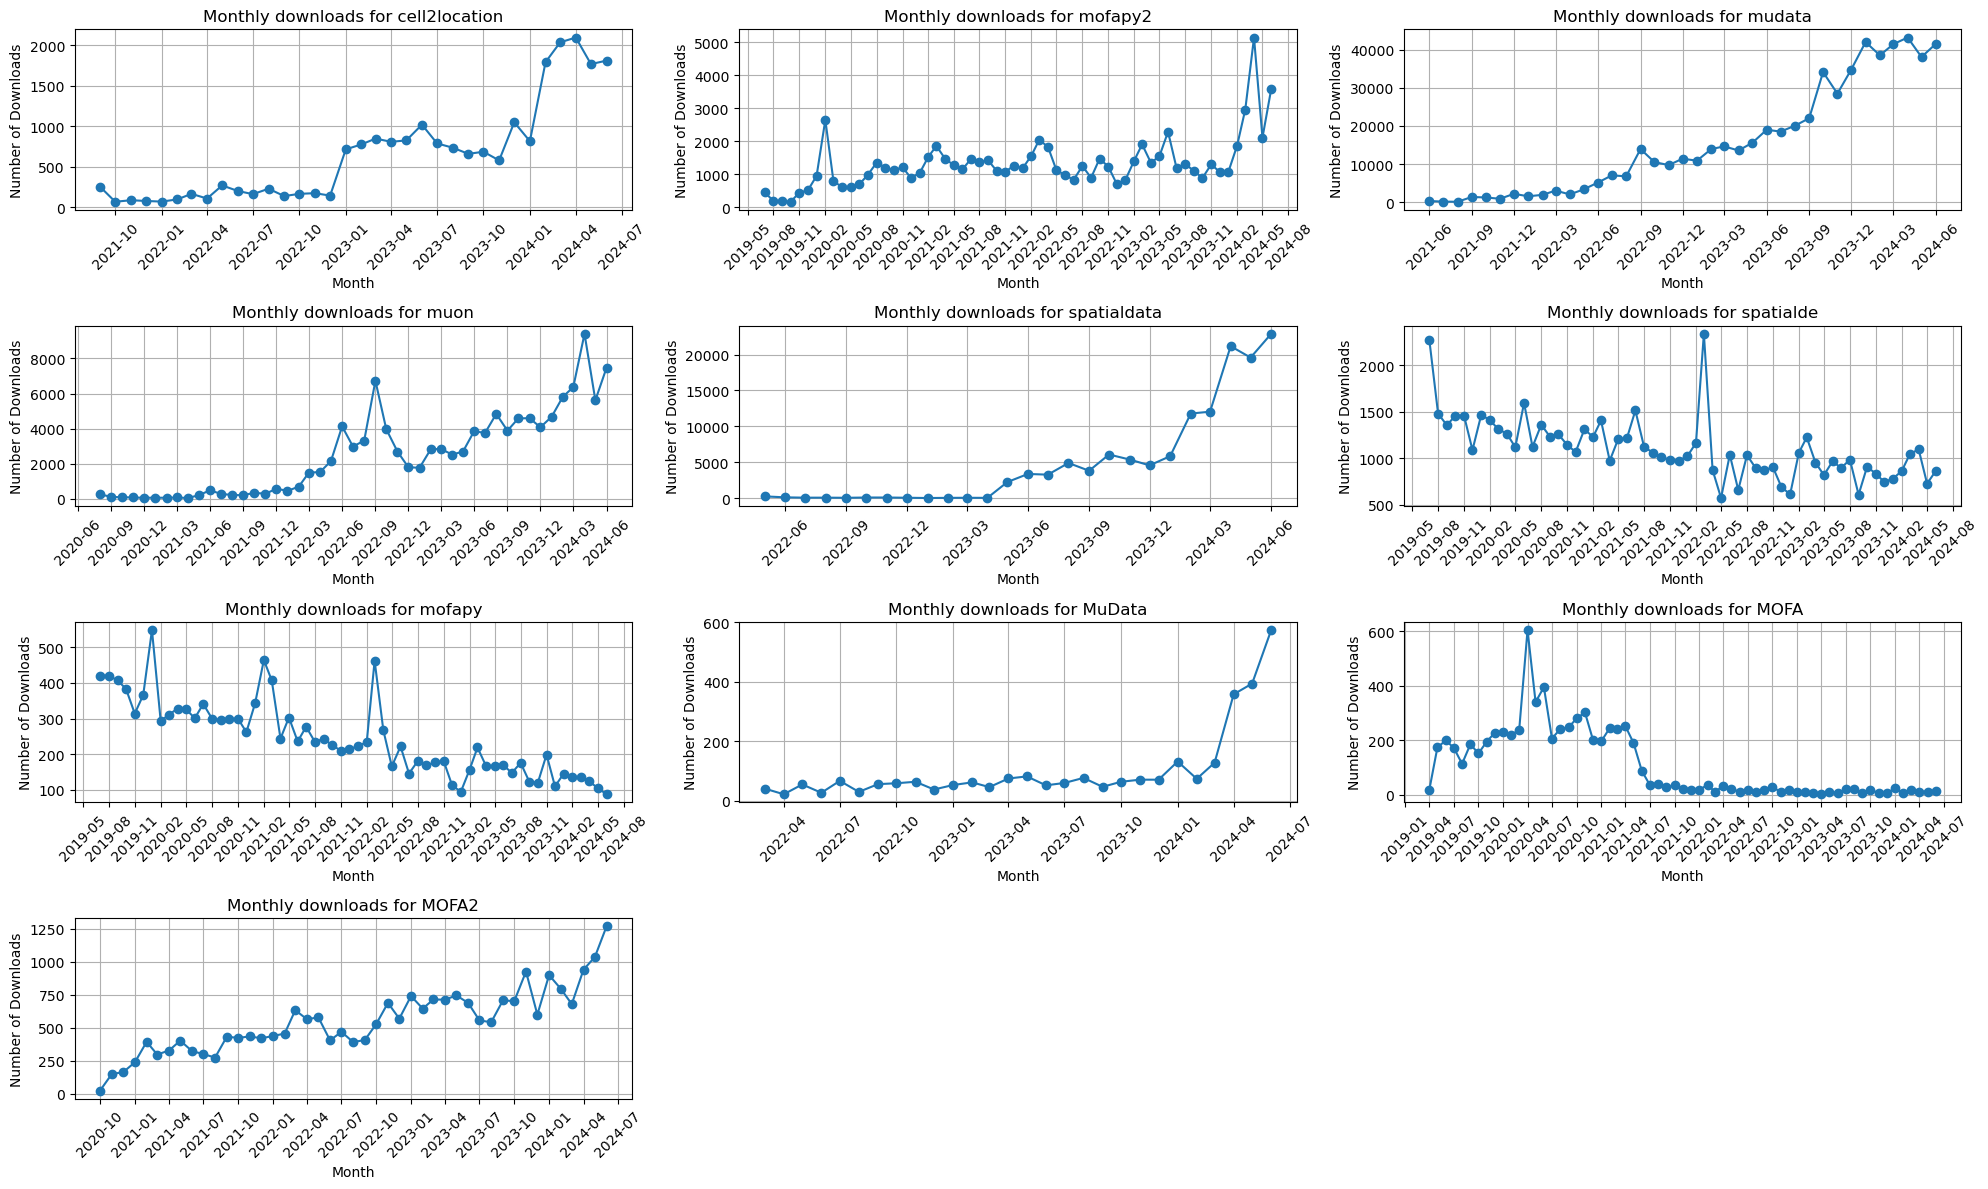

'monthly_downloads_plots.pdf'

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Assuming `data` is your DataFrame containing the data
# and `projects` is a list of project names

# Create a PDF with a grid of plots for all projects
pdf_path = 'monthly_downloads_plots.pdf'

# Define the grid size (e.g., 2 rows and 3 columns for up to 6 projects)
rows = 4
cols = 3

with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for i, project in enumerate(projects):
        project_data = data[data['project'] == project]
        ax = axes[i]
        ax.plot(project_data['month'], project_data['num_downloads'], marker='o')
        ax.set_title(f'Monthly downloads for {project}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Downloads')
        ax.grid(True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path


In [19]:
data['project'] = data['project'].apply(lambda x: 'MOFA' if x in ['MOFA', 'mofapy', 'mofapy2', 'MOFA2'] else 'mudata' if x in ['MuData', 'mudata'] else x)
data = data.groupby(['project', 'month'], as_index=False).sum()

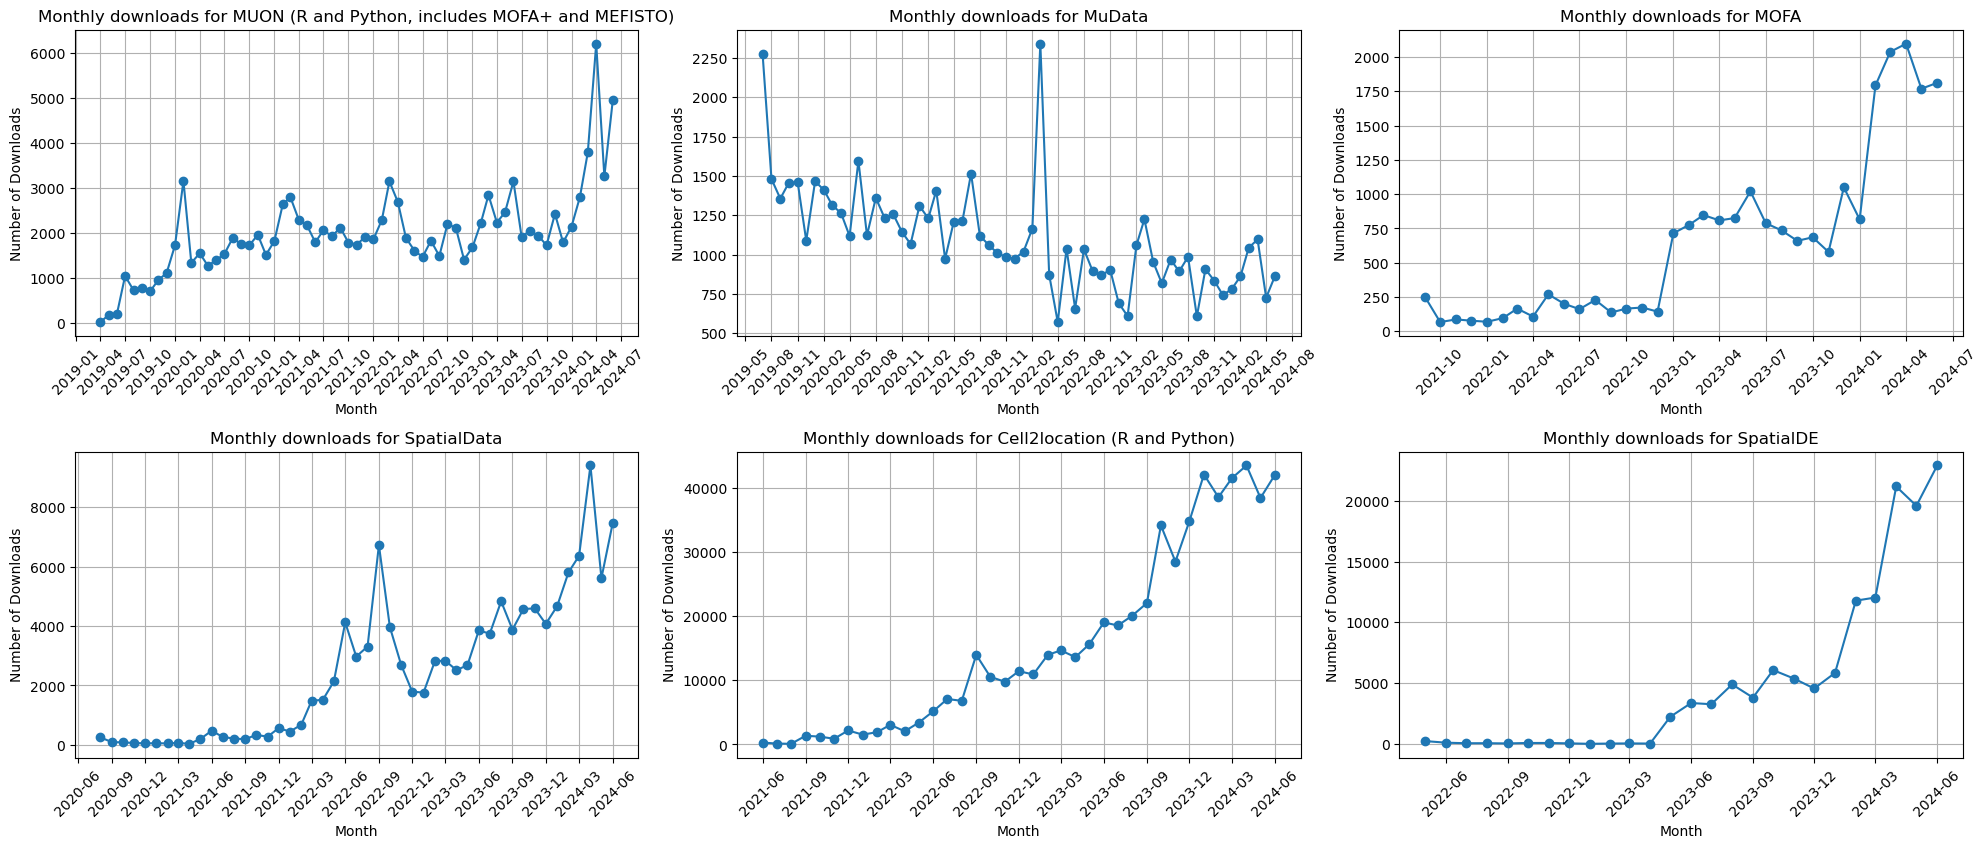

'monthly_downloads_plots.pdf'

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

projects = data['project'].unique()
manual_order = ['MOFA', 'spatialde', 'cell2location', 'muon', 'mudata', 'spatialdata']
assert len(projects) == len(manual_order)
title_name = dict(zip(manual_order, ['MUON', 'MuData', 'MOFA', 'SpatialData', 'Cell2location', 'SpatialDE']))

# Assuming `data` is your DataFrame containing the data
# and `projects` is a list of project names

# Create a PDF with a grid of plots for all projects
pdf_path = 'monthly_downloads_plots.pdf'

# Define the grid size (e.g., 2 rows and 3 columns for up to 6 projects)
rows = 3
cols = 3

with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for i, project in enumerate(manual_order):
        project_data = data[data['project'] == project]
        ax = axes[i]
        ax.plot(project_data['month'], project_data['num_downloads'], marker='o')
        title = f'Monthly downloads for {title_name[project]}'
        if project == 'MOFA':
            title += ' (R and Python, includes MOFA+ and MEFISTO)'
        if project == 'mudata':
            title += ' (R and Python)'
        ax.set_title(title)
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Downloads')
        ax.grid(True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    pdf.savefig()
    plt.show()
    plt.close()

pdf_path
